In [1]:
import os
import random

import h5py
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize
from sklearn.model_selection import train_test_split

In [2]:
def load_file(filename: str) -> tuple[np.ndarray, np.ndarray]:
    """Load in the phase and fluorescent data from a file."""
    with h5py.File(filename, "r") as f:
        phase = f["Efield_phase"][:]
        fluorescent = f["Fluo"][:]
    
    return phase, fluorescent

def load_directory(dir: str = "data/") -> tuple[np.ndarray, np.ndarray]:
    """Load in all the files in a directory."""
    all_phase = []
    all_fluorescent = []
    
    for filename in os.listdir(dir):
        if filename.endswith(".mat"):
            phase, fluorescent = load_file(os.path.join(dir, filename))
            all_phase.append(phase)
            all_fluorescent.append(fluorescent)
    
    return np.concatenate(all_phase), np.concatenate(all_fluorescent)


images, labels = load_directory()

images.shape, labels.shape

((40, 1036, 1036), (40, 2200, 2200))

In [3]:
# Remove images where the phase wasn't captured correctly
images_to_remove = [14, 15, 18, 21, 22, 23, 24, 25, 26]

images = np.delete(images, images_to_remove, axis=0)
labels = np.delete(labels, images_to_remove, axis=0)

images.shape, labels.shape

((31, 1036, 1036), (31, 2200, 2200))

In [4]:
# Resize the images to the same size
output_shape = (1024, 1024)

images = np.array([resize(img, output_shape) for img in images])
labels = np.array([resize(img, output_shape) for img in labels])

images.shape, labels.shape

((31, 1024, 1024), (31, 1024, 1024))

In [5]:
# Normalize the fluorescent images
for i in range(len(labels)):
    labels[i] /= labels[i].max()

# Threshold the fluorescent images
labels = np.array(labels > 0.5, dtype=np.uint8)

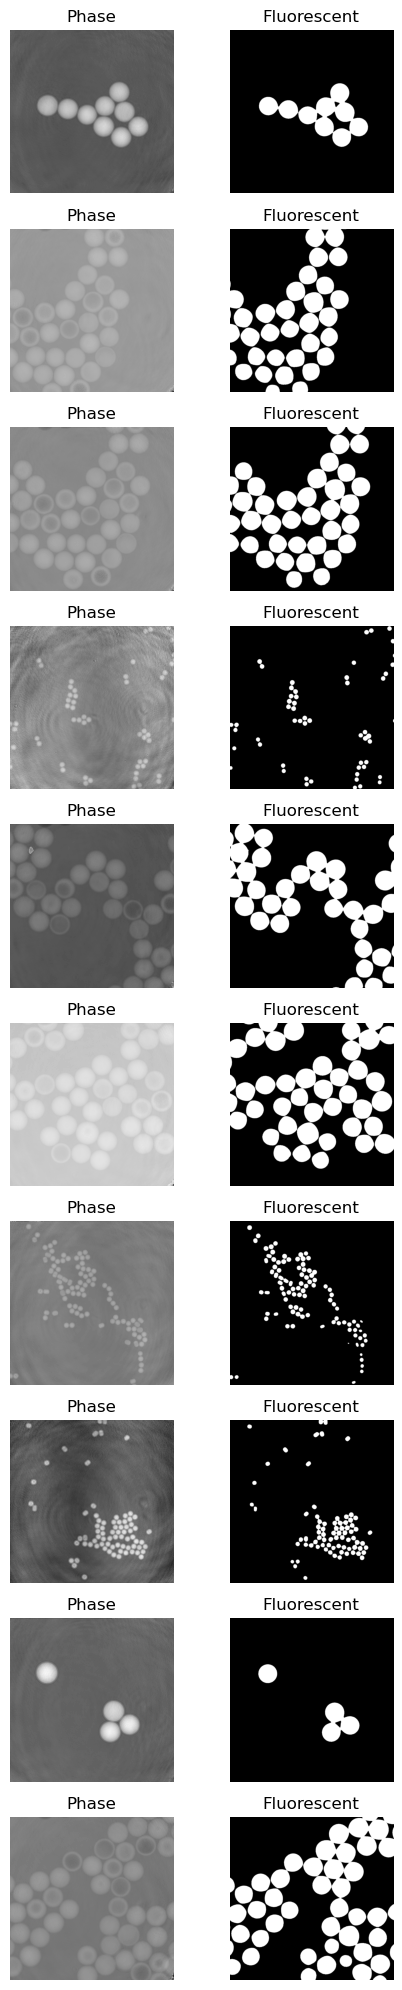

In [6]:
# Lets take a final look at our data
num_images = 10

# Get random indices for the images
random_indices = random.sample(range(len(labels)), num_images)

# Display the images
fig, axes = plt.subplots(num_images, 2, figsize=(5, 20))

for i, idx in enumerate(random_indices):
    axes[i, 0].imshow(images[idx], cmap="gray")
    axes[i, 0].set_title("Phase")
    axes[i, 0].axis("off")
    
    axes[i, 1].imshow(labels[idx], cmap="gray")
    axes[i, 1].set_title("Fluorescent")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()


In [7]:
# # One hot encode the labels
# unique_labels = np.unique(labels)

# labels = np.ndarray((len(labels), len(unique_labels), *output_shape), dtype=np.uint8)

# for label in unique_labels:
#     labels[:, label][labels == label] = 1

In [8]:
# Split into training and testing data
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2)

In [9]:
def write_data(images: np.ndarray, labels: np.ndarray, output_dir: str = "data/", filename: str = "microspheres.h5"):
    """Write the phase and fluorescent data to a new file."""
    os.makedirs(output_dir, exist_ok=True)

    with h5py.File(os.path.join(output_dir, filename), "w") as f:
        f.create_dataset("images", data=images)
        f.create_dataset("labels", data=labels)

write_data(train_images, train_labels, filename="train.h5")
write_data(test_images, test_labels, filename="test.h5")